In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sqlalchemy
# Connect to database
PWD='root'
USR='root'
SQLALCHEMY_DATABASE_URI = 'mysql+pymysql://{}:{}@localhost:3306/gdb0041'.format(USR, PWD)
engine = sqlalchemy.create_engine(SQLALCHEMY_DATABASE_URI)

**P&L Statement**<br />
Gross = 50<br />
pre-Invoice deduction = 5(for regular customer)<br />
Net-Invoice-sales = 45<br />
post-Invoice deduction = 5(display priority fee)<br />
Net-Sales = 40<br />
COGS = 20 (COST OF GOODS SOLD)<br />
Margin = 20<br />
margin % = 50 (M/NS)<br />

Find the croma customer aggregated by product in monthly basis

In [4]:
query = """
select * from dim_customer 
"""
df_dim_customer = pd.read_sql(query,engine)
#df_dim_customer['customer'].unique()
df_dim_customer[df_dim_customer['customer'] == 'Croma']

,customer_code,customer,platform,channel,market,sub_zone,region
48,90002002,Croma,Brick & Mortar,Retailer,India,India,APAC


To create a fiscal year calendar, add 4 months to the calendar date in the database where September marks the fiscal year's start

In [12]:
query = """
select *,
(CASE when Month(date) in (9,10,11) Then 'Q1'
     when Month(date) in (12,1,2) Then 'Q2'
     when Month(date) in (3,4,5) Then 'Q3' else 'Q4' END ) AS Quater
 from fact_sales_monthly
where customer_code = 90002002 and
year(date_add(date,interval 4 month)) = 2021 and
(CASE when Month(date) in (9,10,11) Then 'Q1'
     when Month(date) in (12,1,2) Then 'Q2'
     when Month(date) in (3,4,5) Then 'Q3' else 'Q4' END )='Q1'
"""
df_fact_sales_monthly = pd.read_sql(query,engine)
print(df_fact_sales_monthly.tail())
print(df_fact_sales_monthly['Quater'].unique())

           date product_code  customer_code  sold_quantity Quater
663  2020-10-01  A7321160301       90002002            479     Q1
664  2020-09-01  A7321160302       90002002            507     Q1
665  2020-10-01  A7321160302       90002002            243     Q1
666  2020-09-01  A7321160303       90002002            190     Q1
667  2020-10-01  A7321160303       90002002            586     Q1
['Q1']


In [13]:
query = """
select m.date,m.product_code,
       p.product,p.variant,m.sold_quantity,
       gp.gross_price,round(m.sold_quantity*gp.gross_price,2) as Total_gp
 from fact_sales_monthly m
 join dim_product p on p.product_code = m.product_code
 join fact_gross_price gp on gp.product_code = m.product_code and gp.fiscal_year = get_fiscal_year(m.date)
where customer_code = 90002002 and
get_fiscal_year(date) = 2021;
"""
fact_sales_monthly = pd.read_sql(query,engine)
print(fact_sales_monthly.tail())

            date product_code          product  variant  sold_quantity  \
3001  2021-02-01  A7321160303  AQ Wi Power Dx3  Premium            186   
3002  2021-04-01  A7321160303  AQ Wi Power Dx3  Premium            148   
3003  2021-05-01  A7321160303  AQ Wi Power Dx3  Premium            487   
3004  2021-06-01  A7321160303  AQ Wi Power Dx3  Premium            289   
3005  2021-08-01  A7321160303  AQ Wi Power Dx3  Premium            158   

      gross_price  Total_gp  
3001      42.8483   7969.78  
3002      42.8483   6341.55  
3003      42.8483  20867.12  
3004      42.8483  12383.16  
3005      42.8483   6770.03  


Croma month wise Total Sales Amount

In [14]:
query = """
select m.date,
       sum(round(m.sold_quantity*gp.gross_price,2)) as Total_gp
 from fact_sales_monthly m
 join fact_gross_price gp on gp.product_code = m.product_code and gp.fiscal_year = get_fiscal_year(m.date)
where customer_code = 90002002 
group by m.date
order by m.date desc;
"""
fact_sales_monthly = pd.read_sql(query,engine)
print(fact_sales_monthly.tail())

          date   Total_gp
34  2018-02-01  144799.54
35  2018-01-01  127574.73
36  2017-12-01  245673.84
37  2017-10-01  162687.56
38  2017-09-01  122407.57


In [15]:
query = """
with cte_pre_invoice as
(
select m.date,Year(adddate(m.date,interval 4 month)) as fiscal_year,
		m.product_code,m.sold_quantity, p.product,p.variant,c.market, gp.gross_price,
        round(m.sold_quantity*gp.gross_price,2) as Total_gp,pd.pre_invoice_discount_pct
from fact_sales_monthly m 
 join dim_product p on p.product_code = m.product_code
 join dim_customer c on c.customer_code = m.customer_code
 join fact_gross_price gp on gp.product_code = m.product_code and gp.fiscal_year = get_fiscal_year(m.date)
 join fact_pre_invoice_deductions pd on pd.customer_code = m.customer_code and pd.fiscal_year = get_fiscal_year(m.date)
where m.customer_code in (90002002,90020102,70019204)
)select *,
round((1-pre_invoice_discount_pct)*Total_gp,2) as Net_Invoice_Sales 
from  cte_pre_invoice;
"""
top_customer = pd.read_sql(query,engine)
print(top_customer.tail())

            date  fiscal_year product_code  sold_quantity          product  \
8179  2021-06-01         2021  A7321160303            289  AQ Wi Power Dx3   
8180  2021-08-01         2021  A7321160303            158  AQ Wi Power Dx3   
8181  2021-09-01         2022  A7321160303            759  AQ Wi Power Dx3   
8182  2021-10-01         2022  A7321160303            169  AQ Wi Power Dx3   
8183  2021-12-01         2022  A7321160303            523  AQ Wi Power Dx3   

      variant market  gross_price  Total_gp  pre_invoice_discount_pct  \
8179  Premium  India      42.8483  12383.16                    0.3025   
8180  Premium  India      42.8483   6770.03                    0.3025   
8181  Premium  India      43.5559  33058.93                    0.1828   
8182  Premium  India      43.5559   7360.95                    0.1828   
8183  Premium  India      43.5559  22779.74                    0.1828   

      Net_Invoice_Sales  
8179            8637.25  
8180            4722.10  
8181          

In [16]:
g = top_customer.groupby('market')['Total_gp'].sum()
g

market
India    79236070.63
Name: Total_gp, dtype: float64

In [17]:
g = top_customer.groupby('variant')['Net_Invoice_Sales'].sum().sort_values(ascending=False)
g

variant
Standard               6244198.47
Premium                6010485.22
Plus                   4490806.69
Plus 2                 4192448.91
Plus 1                 3515938.63
Premium Black          3165711.76
Premium 2              3066281.93
Premium 1              2988717.71
Premium Misty Green    2859284.03
Standard 2             2686938.67
Standard 1             2553275.11
Standard Grey          2062098.93
Standard Blue          1947320.39
Standard Red           1880020.15
Plus Blue              1870028.30
Plus Red               1741912.84
Plus Grey              1419169.15
Plus Black             1320964.94
Standard 3             1268834.59
Plus Cool Blue         1237185.62
Plus 3                 1207740.23
Plus Firey Red         1064114.15
Standard Firey Red     1013481.69
Standard Black          995506.41
Standard Cool Blue      845841.28
Plus 1                  166064.41
Premium Plus             96311.54
Name: Net_Invoice_Sales, dtype: float64

In [6]:
query = """
select *,
((1- Incude_other_postdeduction)*Net_Invoice_Sales) as Net_sale
from net_sales_vw
where customer_code in (90002002,90020102,70019204);
"""
top_customer = pd.read_sql(query,engine)
print(top_customer.head())

         date  fiscal_year product_code  customer_code  sold_quantity  \
0  2017-09-01         2018  A0118150101       90002002             40   
1  2017-09-01         2018  A0118150101       90002002             40   
2  2017-09-01         2018  A0118150101       90002002             40   
3  2017-09-01         2018  A0118150101       90002002             40   
4  2017-09-01         2018  A0118150101       90002002             40   

                                             product   variant customer  \
0  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  Standard    Croma   
1  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  Standard    Croma   
2  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  Standard    Croma   
3  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  Standard    Croma   
4  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  Standard    Croma   

  market   channel region  gross_price  Total_gp  pre_invoice_discount_pct  \
0  India  Retailer   APAC      1

In [28]:
top_customer['Net_sale_mln'] = top_customer['Net_sale'].apply(lambda x: x/1000000)
top_customer.tail(1)

,date,fiscal_year,product_code,customer_code,sold_quantity,product,variant,customer,market,channel,region,gross_price,Total_gp,pre_invoice_discount_pct,Net_Invoice_Sales,Incude_other_postdeduction,Net_sale,Net_sale_mln
517028,2021-12-01,2022,A7321160303,90020102,26,AQ Wi Power Dx3,Premium,Fnac-Darty,Austria,Retailer,EU,43.5559,1132.45,0.3011,791.47,0.3724,496.726572,0.000497


In [21]:
g = top_customer.groupby('customer')['Net_sale_mln'].sum()
g

customer
Atliq e Store      39.874998
Croma            1103.459823
Fnac-Darty         26.633251
Name: Net_sale_mln, dtype: float64

<Axes: ylabel='customer'>

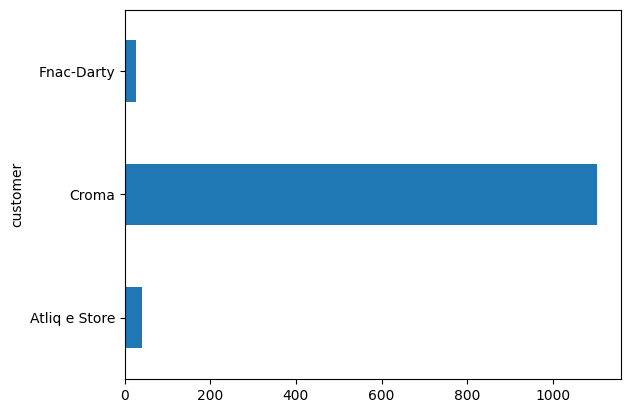

In [24]:
g.plot(kind='barh')

In [25]:
top_customer.groupby('market')['Net_sale_mln'].sum()

market
Austria      26.633251
India      1103.459823
Sweden       39.874998
Name: Net_sale_mln, dtype: float64

In [26]:
top_customer.groupby('channel')['Net_sale_mln'].sum()

channel
Direct        39.874998
Retailer    1130.093074
Name: Net_sale_mln, dtype: float64

In [27]:
top_customer.groupby('region')['Net_sale_mln'].sum()

region
APAC    1103.459823
EU        66.508249
Name: Net_sale_mln, dtype: float64